In [33]:
# !pip install pandas
# !pip install --upgrade praw
# !pip install networkx
# !pip install matplotlib
# !pip install plotly
# !pip install numpy
# !pip install scikit-learn
# !pip install wordcloud
# !pip install nltk
# !pip install chardet


In [32]:
from datetime import datetime
import pandas as pd
import praw
import json
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from sklearn.cluster import KMeans


from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re

In [10]:
import praw
import json
from datetime import datetime

# Function to read credentials from a JSON file
def load_credentials(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load credentials
credentials = load_credentials('reddit_secrets.json')

# Initialize PRAW with credentials from the JSON file
reddit = praw.Reddit(client_id=credentials['client_id'],
                     client_secret=credentials['client_secret'],
                     user_agent=credentials['user_agent'])

# Function to check if the post is related to MAC cosmetics
def is_mac_related(text):
    # keywords = [
    #     "MAC", "Mac cosmetics", "MAC lipstick", "MAC makeup",
    #     "MAC Studio Fix", "MAC Pro Longwear", "MAC Mineralize", "MAC Prep + Prime", "MAC Viva Glam",
    #     "Ruby Woo lipstick", "Cremesheen Lipstick", "Retro Matte", "MAC Eyeshadow", "MAC Foundation",
    #     "MAC Concealer", "Fluidline", "Fix+ Spray", "Strobe Cream",
    #     "MAC blush", "MAC mascara", "MAC eyeliner", "MAC brush", "MAC palette", "MAC skin", "MAC face",
    #     "Rihanna MAC", "Selena MAC", "MAC Holiday Collection", "MAC Summer Collection",
    #     "M·A·C", "M.A.C.", "mac makeup", "mac cosmetics", "mac beauty products",
    #     "#MACCosmetics", "#MACLovers", "#MACMakeup", "#MACArtist", "#MACAddict",
    #     "Professional makeup", "Cosmetic artistry", "Beauty influencer MAC", "Makeup tutorial MAC"
    # ]
    keywords = [
        ""
    ] 
    return any(keyword.lower() in text.lower() for keyword in keywords)

# Function to get comments from a post
def get_comments(submission):
    submission.comments.replace_more(limit=0)  # Load all comments
    comments = []
    for comment in submission.comments.list():
        if str(comment.author) != 'None':
            comments.append({
                'author': str(comment.author),
                'body': comment.body,
                'created_utc': datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                'score': comment.score
            })
    return comments


# Function to get author details
def get_author_details(author_name):
    try:
        author = reddit.redditor(author_name)
        author_subreddit = author.subreddit  # Get the UserSubreddit object
        return {
            'name': author.name,
            'description': author_subreddit.public_description if author_subreddit else None,
            'total_karma': author.link_karma + author.comment_karma,  # Total karma (post + comment)
            'link_karma': author.link_karma,  # Link karma
            'comment_karma': author.comment_karma,  # Comment karma
            'account_created_utc': datetime.utcfromtimestamp(author.created_utc).isoformat(),  # Account creation date
            'is_employee': author.is_employee,  # Reddit employee status
            'has_verified_email': author.has_verified_email  # Whether the user has a verified email
        }
    except Exception as e:
        print(f"Error fetching author details: {e}")
        return None


# Function to get post details and comments
def get_posts(subreddit_name, keyword_limit=5):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    count = 0

    for post in subreddit.top(limit=None):  # Search through a larger pool of posts
        if is_mac_related(post.title) or is_mac_related(post.selftext) or (str(post.author) != 'None'):
            author_details = get_author_details(str(post.author))
            post_data = {
                'title': post.title,
                'score': post.score,
                'id': post.id,
                'url': post.url,
                # 'author': str(post.author),
                'author_details': author_details,
                'created_utc': datetime.utcfromtimestamp(post.created_utc).isoformat(),
                'num_comments': post.num_comments,
                'selftext': post.selftext,
                'link_flair_text': post.link_flair_text,
                'upvote_ratio': post.upvote_ratio,
                'subreddit': str(post.subreddit),
                'all_awardings': post.all_awardings,
                'permalink': post.permalink,
                'stickied': post.stickied,
                'locked': post.locked,
                'domain': post.domain,
                'comments': get_comments(post)
            }
            posts.append(post_data)
            count += 1
            if count >= keyword_limit:
                break
    return posts

# Extract MAC-related posts and comments from the subreddit
subreddit_name = 'BurgerKing'
data = get_posts(subreddit_name, keyword_limit=10)

# Save data to a JSON file
with open('reddit_data_BurgerKing.json', 'w') as file:
    json.dump(data, file, indent=4)

print("Data saved to 'reddit_data_BurgerKing.json'")


Data saved to 'reddit_data_BurgerKing.json'


In [11]:
# Load data
with open('reddit_data_BurgerKing.json', 'r') as file:
    data = json.load(file)

# Create a graph
G = nx.Graph()

# Add nodes and edges
for item in data:
    if item['author_details'] == None:
        print(item)
    post_author = item['author_details']['name']
    G.add_node(post_author)

    for comment in item['comments']:
        commenter = comment['author']
        G.add_node(commenter)
        G.add_edge(post_author, commenter)  # Create an edge between post author and commenter


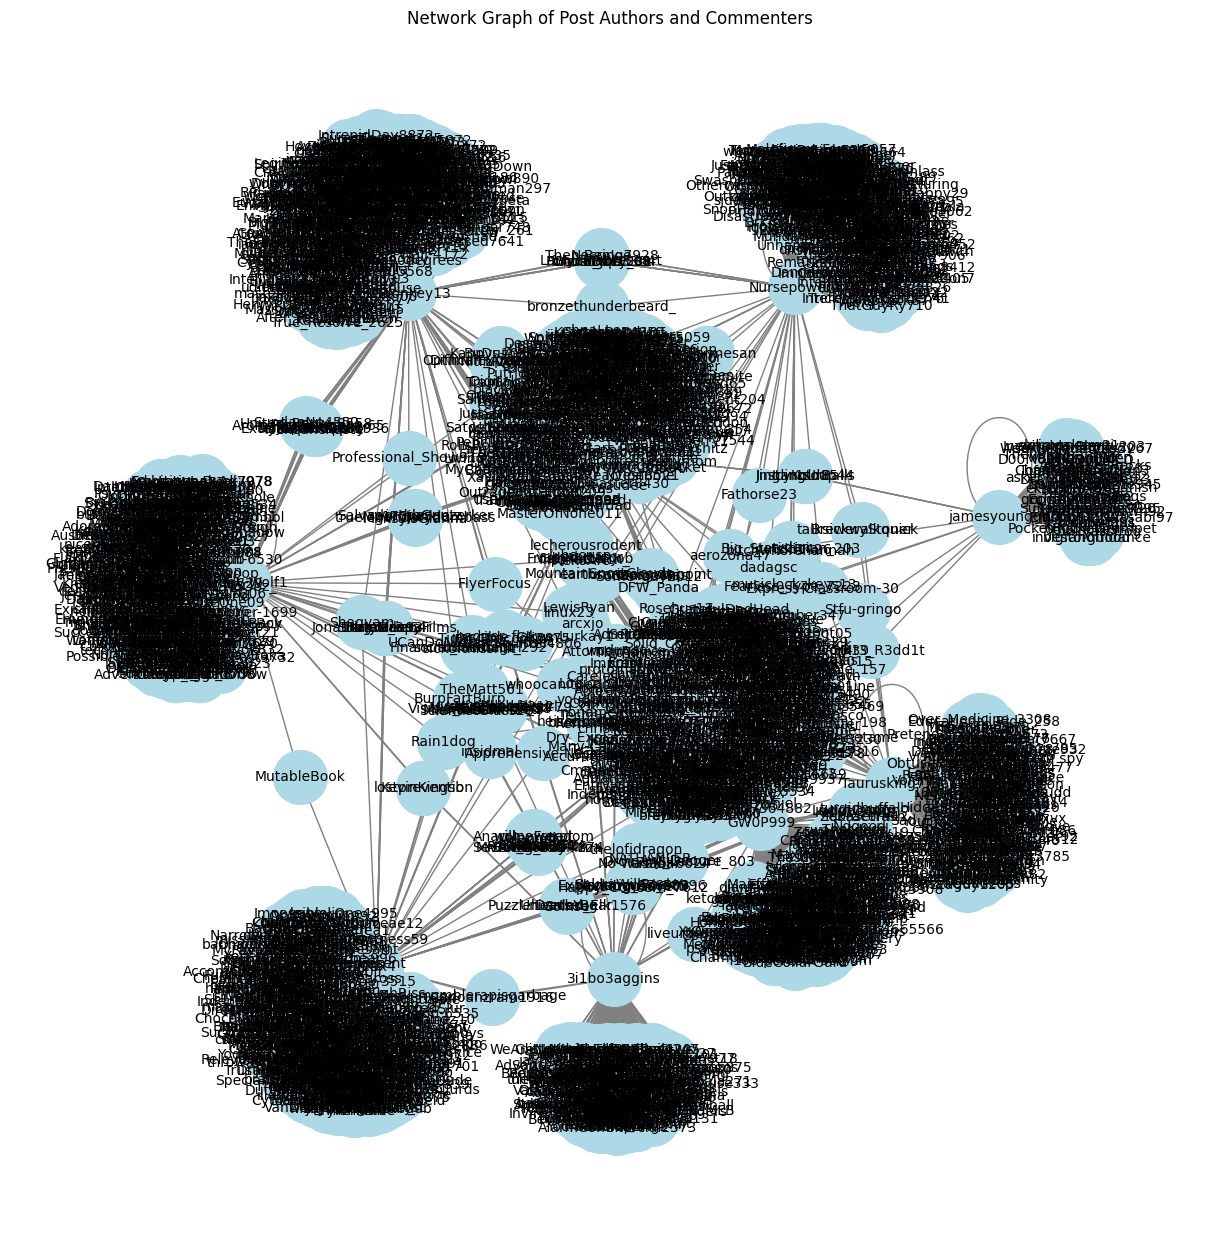

In [12]:
# Draw the network
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', 
        node_size=1500, font_size=10)
plt.title("Network Graph of Post Authors and Commenters")
plt.show()


In [13]:
# Get positions for the nodes in G
pos = nx.spring_layout(G)

# For each edge, we need to extract the positions of the start and end nodes
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create a trace for the edges
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# For each node, we need to extract the positions and centrality measures
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Create a trace for the nodes
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        color=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Color node points by the number of connections
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'{adjacencies[0]} (# of connections: {len(adjacencies[1])})')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network Graph of Post Authors and Commenters',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()


In [14]:
# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Display top influencers
top_influencers = sorted_centrality[:5] 



In [15]:
print("Top influencers based on degree centrality:")

df_top_influencers = pd.DataFrame(top_influencers, columns=['Contributor', 'Degree Centrality'])

df_top_influencers

Top influencers based on degree centrality:


Contributor  Degree Centrality
0     13donkey13           0.162782
1   imjacksissue           0.155400
2          rehx4           0.149573
3    Daddy-Wolf1           0.130148
4  Jenkem-Boofer           0.115773

In [23]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Define a set of English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/ankush/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankush/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ankush/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/ankush/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
# Extend the stopwords list with custom words
additional_stopwords = {'like', 'people', 'think', 'would', 'know', 'also', 'even', 'one', 'really', 'get', 
                        'thing', 'https', 'really', 'use', 'year', 'lol'}
extended_stopwords = set(stopwords.words('english')).union(additional_stopwords)

def preprocess_text(text):
    # Decode and re-encode text to handle encoding issues
    # text = text.encode('latin-1').decode('unicode_escape').encode('latin-1').decode('utf-8')

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|@\w+|\#\w+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and custom additional words
    tokens = [token for token in tokens if token not in extended_stopwords]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Filter only nouns
    nouns = [word for word, pos in pos_tag(tokens) if pos.startswith('NN')]

    # Remove short words (less than 3 characters) and digits
    nouns = [word for word in nouns if len(word) > 2 and not word.isdigit()]

    return nouns

In [16]:
num_comments_per_contributor = {}

for item in data:
    # Count the post itself by the author
    post_author = item['author_details']['name']
    num_comments_per_contributor[post_author] = num_comments_per_contributor.get(post_author, 0) + 1

    # Iterate through comments and count them
    for comment in item['comments']:
        commenter = comment['author']
        num_comments_per_contributor[commenter] = num_comments_per_contributor.get(commenter, 0) + 1

In [17]:
num_comments_per_contributor

{'jamesyounggg': 2,
 'investorguidance': 1,
 'JinglingUrBalls': 2,
 'Business-Parsnip-939': 6,
 'Brad8e': 1,
 'aerozona47': 4,
 'moobeemu': 1,
 'Inevitable-Plenty203': 1,
 'plumangus': 1,
 'Weekly-Patience-5267': 1,
 'The0nlyPhantom': 1,
 'IcyKold85': 5,
 'FUPAMaster420': 1,
 'PocketRocketTrumpet': 1,
 'VanFkingHalen': 1,
 '1_H4t3_R3dd1t': 7,
 'alexcd421': 1,
 'ItsmyDZNA': 1,
 'Fearless_Type_7223': 5,
 'Stauce52': 1,
 'Eclipse_Private': 1,
 'bigfanoffood': 1,
 'askepticalskeptic': 1,
 'MidniteOG': 1,
 'skrimpskampi': 1,
 'DannysFavorite945': 1,
 'D00M0RBED00MED': 1,
 'DjCramYo': 1,
 'bparry1192': 1,
 'Instantsoup44': 2,
 'chinchila5': 1,
 'grumpydad24': 1,
 'Donut153': 1,
 'CosmicDust20': 1,
 'Turtlesquirtzcody': 1,
 'DowntownAtown92': 1,
 'TheGeeeb': 1,
 'Stfu-gringo': 2,
 'Funkyassfrog': 1,
 'musiclockzkeys13': 4,
 'redrider456': 1,
 'swiminpool': 1,
 'fnscarcasm': 1,
 'Spooky_Legs': 1,
 'mkaymeow21': 1,
 'NougatNewt': 1,
 'amor_fati_42': 1,
 'Slimey_700': 1,
 'Substantial-Dig9995': 

In [101]:
contributor_texts = {}

for item in data:
    # Count the post itself by the author
    post_author = item['author_details']['name']
    text_comm = [' '.join(preprocess_text(item['title'])) + ' ' + ' '.join(preprocess_text(item['selftext']))]
    if text_comm != ['']:
        contributor_texts[post_author] = contributor_texts.get(post_author, []) + text_comm
    else:
        contributor_texts[post_author] = contributor_texts.get(post_author, [])

    # Iterate through comments and count them
    for comment in item['comments']:
        commenter = comment['author']
        text_comm = [' '.join(preprocess_text(comment['body']))]
        if text_comm != ['']:
            contributor_texts[commenter] = contributor_texts.get(commenter, []) + text_comm
        else:
            contributor_texts[commenter] = contributor_texts.get(commenter, [])

In [102]:
contributor_texts

{'jamesyounggg': ['burger planet ', 'koh phi phi thailand'],
 'investorguidance': ['knew thailand'],
 'JinglingUrBalls': ['burger view gas station drug hooker',
  'lotion mah boi ashy'],
 'Business-Parsnip-939': ['bait switch',
  'meal',
  'bro slice tomato strip half tortilla'],
 'Brad8e': ['chicken sandwich cheese'],
 'aerozona47': ['thailand', 'fakeflation', 'america'],
 'moobeemu': ['thailand koh phi phi damn nowadays'],
 'Inevitable-Plenty203': ['irony photo marvel nature background taint food capitalism foreground'],
 'plumangus': ['chicken aristocrat lady beauty madison summer longer knowledge eat thank'],
 'Weekly-Patience-5267': ['burger support israel'],
 'The0nlyPhantom': ['miss'],
 'IcyKold85': ['yup life',
  'onion lettuce ftw',
  'mcdonald hash taste everything make',
  'whopper wednesday'],
 'FUPAMaster420': ['vibe image vein'],
 'PocketRocketTrumpet': ['fuck thailand spend money fly round world hope thailand food tho'],
 'VanFkingHalen': ['burger emperor'],
 '1_H4t3_R3d

In [103]:
degree_centrality = nx.degree_centrality(G)


# Prepare the feature matrix X
contributors = list(degree_centrality.keys())  # List of contributors
features = []
for contributor in contributors:
    features.append([
        degree_centrality[contributor],  # Degree centrality
        num_comments_per_contributor.get(contributor, 0)  # Number of comments, default to 0 if not found
    ])
X = np.array(features)


In [104]:
# Combine all texts for each contributor into a single string
combined_texts = [' '.join(contributor_texts[contributor]) for contributor in contributors]

# Create a TF-IDF vectorizer and transform the combined texts
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Limit the number of features to the top 50 terms
X_tfidf = tfidf_vectorizer.fit_transform(combined_texts)

# Convert to array
X_tfidf_array = X_tfidf.toarray()


In [106]:
# Combine degree centrality and number of comments with TF-IDF features
X_combined = np.hstack([X, X_tfidf_array])


In [129]:
X_combined.shape

(2575, 52)

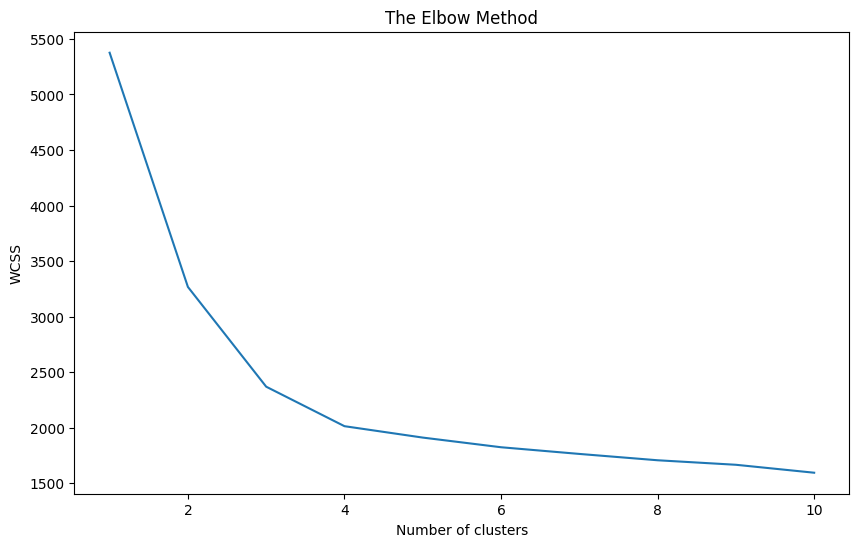

In [107]:
# Use the elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_combined)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The Elbow'
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()


In [108]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=4, n_init=10)
clusters = kmeans.fit_predict(X_combined)


# Assign cluster labels to each contributor
contributors_cluster = {contributor: cluster_label for contributor, cluster_label in zip(contributors, clusters)}


In [109]:
clusters

array([3, 0, 3, ..., 0, 0, 0], dtype=int32)

In [110]:
contributors_cluster

{'jamesyounggg': 3,
 'investorguidance': 0,
 'JinglingUrBalls': 3,
 'Business-Parsnip-939': 2,
 'Brad8e': 0,
 'aerozona47': 3,
 'moobeemu': 0,
 'Inevitable-Plenty203': 0,
 'plumangus': 0,
 'Weekly-Patience-5267': 0,
 'The0nlyPhantom': 0,
 'IcyKold85': 2,
 'FUPAMaster420': 0,
 'PocketRocketTrumpet': 0,
 'VanFkingHalen': 0,
 '1_H4t3_R3dd1t': 2,
 'alexcd421': 0,
 'ItsmyDZNA': 0,
 'Fearless_Type_7223': 2,
 'Stauce52': 0,
 'Eclipse_Private': 0,
 'bigfanoffood': 0,
 'askepticalskeptic': 0,
 'MidniteOG': 0,
 'skrimpskampi': 0,
 'DannysFavorite945': 0,
 'D00M0RBED00MED': 0,
 'DjCramYo': 0,
 'bparry1192': 0,
 'Instantsoup44': 3,
 'chinchila5': 0,
 'grumpydad24': 0,
 'Donut153': 0,
 'CosmicDust20': 0,
 'Turtlesquirtzcody': 0,
 'DowntownAtown92': 0,
 'TheGeeeb': 0,
 'Stfu-gringo': 3,
 'Funkyassfrog': 0,
 'musiclockzkeys13': 3,
 'redrider456': 0,
 'swiminpool': 0,
 'fnscarcasm': 0,
 'Spooky_Legs': 0,
 'mkaymeow21': 0,
 'NougatNewt': 0,
 'amor_fati_42': 0,
 'Slimey_700': 0,
 'Substantial-Dig9995': 

In [111]:
def preprocess_and_tokenize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and stop words, and lower case the words
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    return tokens

# Modify the cluster_texts creation to tokenize the texts
cluster_texts = {}

for item in data:
    contributor = item['author_details']['name']
    if True:#contributor in contributors_cluster:
        cluster_label = contributors_cluster[contributor]

        if cluster_label not in cluster_texts:
            cluster_texts[cluster_label] = []

        processed_post_text = preprocess_text(item['selftext'])
        cluster_texts[cluster_label].extend(processed_post_text)

        for comment in item['comments']:
            contributor = comment['author']
            if contributor in contributors_cluster:
                cluster_label = contributors_cluster[contributor]

                if cluster_label not in cluster_texts:
                    cluster_texts[cluster_label] = []

                processed_comment_text = preprocess_text(comment['body'])
                cluster_texts[cluster_label].extend(processed_comment_text)


In [114]:
cluster_texts.keys()

dict_keys([3, 0, 2, 1])

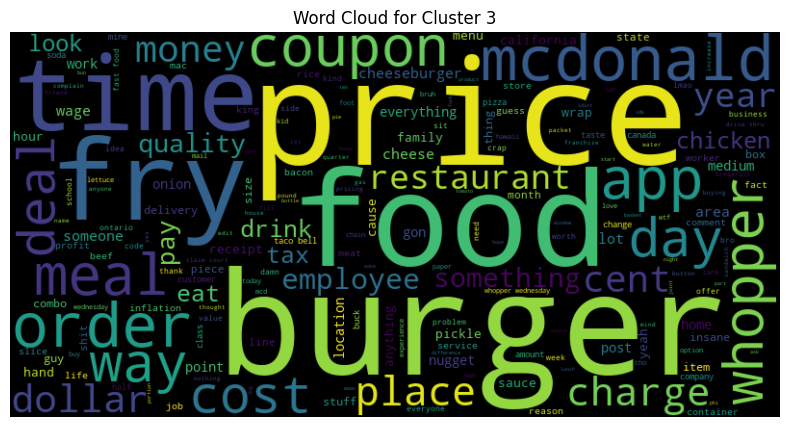

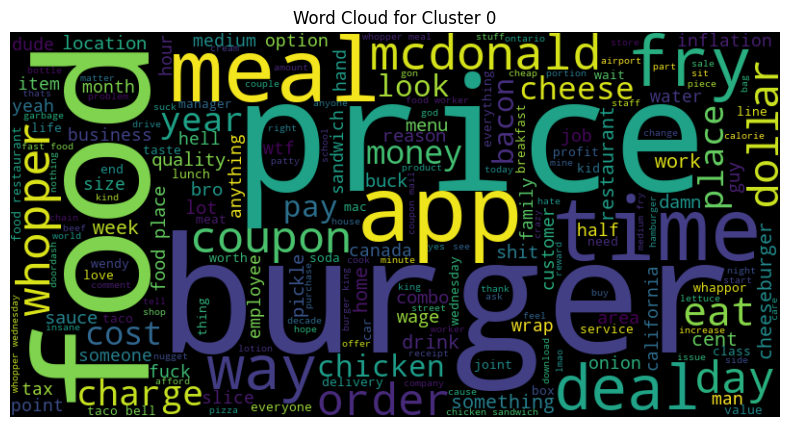

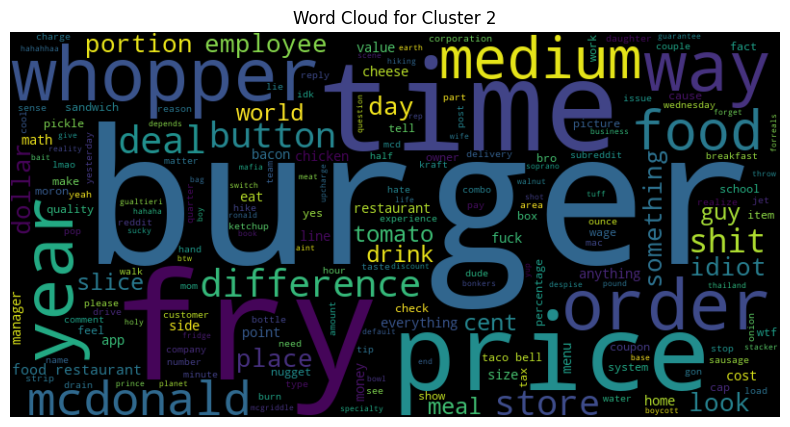

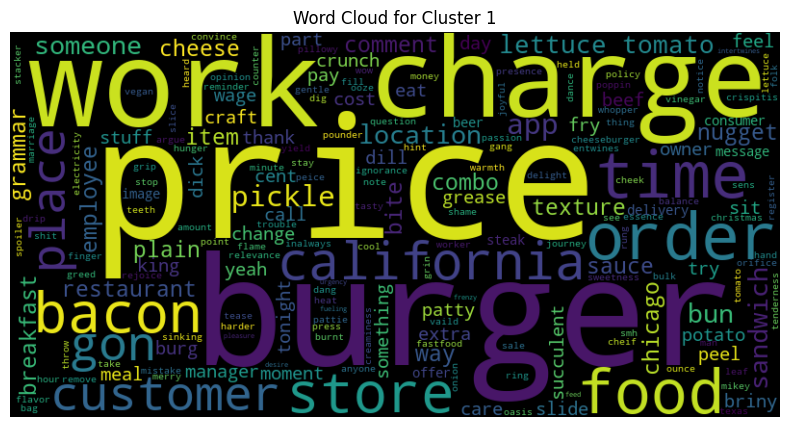

In [115]:
# Process texts and create word clouds for each cluster
for cluster_id, texts in cluster_texts.items():
    # combined_text = " ".join([preprocess_text(text) for text in texts])
    combined_text = " ".join(texts)
    wordcloud = WordCloud(width=800, height=400).generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.show()

In [116]:
# def extract_hashtags(text):
#     # Extract hashtags using regex
#     hashtags = re.findall(r"#(\w+)", text)
#     return " ".join(hashtags)

# # Process texts and create word clouds for hashtags in each cluster
# for cluster_id, texts in cluster_texts.items():
#     combined_hashtags = " ".join([extract_hashtags(text) for text in texts])
#     wordcloud = WordCloud(width=800, height=400).generate(combined_hashtags)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f'Word Cloud for Hashtags in Cluster {cluster_id}')
#     plt.show()


In [117]:

combined_texts = [" ".join(texts) for texts in cluster_texts.values()]

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000)  # Limit number of features to top 1000
X_tfidf = vectorizer.fit_transform(combined_texts)


In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Transpose the TF-IDF matrix so that each row represents a word
X_tfidf_transposed = X_tfidf.transpose()

# Perform hierarchical clustering
Z = linkage(X_tfidf_transposed.toarray(), 'ward')


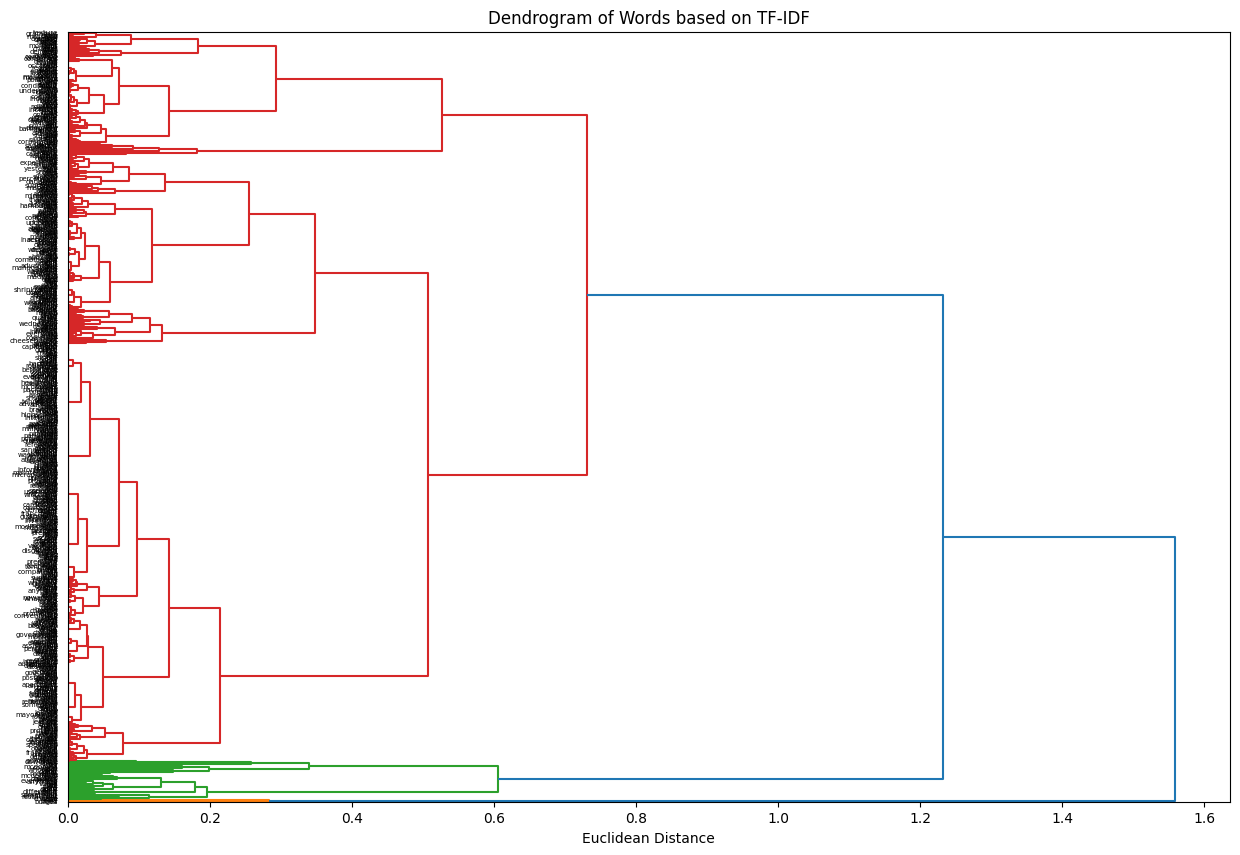

In [119]:
import matplotlib.pyplot as plt

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Plot the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=feature_names, orientation='right')
plt.title("Dendrogram of Words based on TF-IDF")
plt.xlabel("Euclidean Distance")
plt.show()


In [120]:
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram

# Calculate dendrogram information
dendro_info = dendrogram(Z, labels=feature_names, orientation='right', no_plot=True)

# Create Plotly figure
fig = go.Figure()

for i in range(len(dendro_info['icoord'])):
    # Extract the x and y coordinates for each dendrogram line
    x = dendro_info['icoord'][i]
    y = dendro_info['dcoord'][i]

    # Create a line trace for each dendrogram branch
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(color='black', width=1)))

# Add feature names as annotations at the leaves
for i, name in enumerate(dendro_info['ivl']):
    fig.add_annotation(x=dendro_info['leaves'][i], y=0, text=name, showarrow=False, 
                       yshift=10, xanchor='left', align='left')

# Update layout
fig.update_layout(title="Dendrogram of Words based on TF-IDF",
                  xaxis=dict(title="Euclidean Distance"),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  margin=dict(l=0, r=0, t=30, b=0),
                  hovermode='closest')

# Show figure
fig.show()


In [121]:
# and a dictionary 'contributors_cluster' mapping contributors to their clusters

cluster_influence = {cluster: {} for cluster in set(contributors_cluster.values())}

for contributor, cluster in contributors_cluster.items():
    if contributor in G:
        # Degree centrality as a measure of influence
        influence = G.degree[contributor]
        cluster_influence[cluster][contributor] = influence

# Identify top influencer in each cluster
top_influencers = {cluster: max(contributors, key=contributors.get) 
                   for cluster, contributors in cluster_influence.items()}

print("Top influencer in each cluster:", top_influencers)


Top influencer in each cluster: {0: 'rehx4', 1: 'imjacksissue', 2: '13donkey13', 3: 'Taurusking777'}


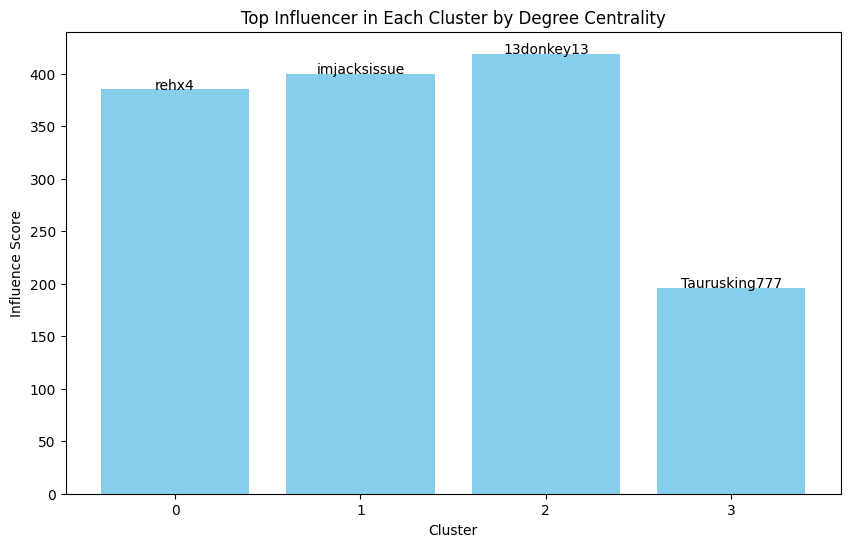

In [122]:
# Prepare data for the graph
clusters = list(top_influencers.keys())
influencers = [top_influencers[cluster] for cluster in clusters]
influence_scores = [cluster_influence[cluster][influencers[idx]] for idx, cluster in enumerate(clusters)]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(clusters, influence_scores, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Influence Score')
plt.title('Top Influencer in Each Cluster by Degree Centrality')
plt.xticks(clusters)
# plt.yticks(range(0, int(max(influence_scores)) + 1))

# Add text labels for the influencers
for idx, score in enumerate(influence_scores):
    plt.text(idx, score + 0.05, influencers[idx], ha='center')

plt.show()

In [123]:
from gensim import corpora, models
import gensim

In [124]:
all_text

['burger',
 'view',
 'gas',
 'station',
 'drug',
 'hooker',
 'thailand',
 'chicken',
 'okay',
 'burger',
 'king',
 'koh',
 'phi',
 'phi',
 'thailand',
 'point',
 'globe',
 'country',
 'sandwich',
 'meme',
 'pee',
 'phuket',
 'ket',
 'fuck',
 'honey',
 'bbq',
 'packet',
 'wtf',
 'koh',
 'phi',
 'phi',
 'travel',
 'plaza',
 'price',
 'advertise',
 'bait',
 'switch',
 'slice',
 'cheese',
 'cost',
 'burger',
 'burger',
 'cost',
 'meal',
 'king',
 'price',
 'cost',
 'cent',
 'airport',
 'location',
 'receipt',
 'airport',
 'location',
 'restaurant',
 'hike',
 'way',
 'day',
 'something',
 'travel',
 'price',
 'stuff',
 'gon',
 'look',
 'travel',
 'plaza',
 'price',
 'franchise',
 'owner',
 'store',
 'slice',
 'buying',
 'neeeed',
 'start',
 'burger',
 'shop',
 'crap',
 'damnnnnn',
 'way',
 'right',
 'inflation',
 'hooker',
 'fucker',
 'need',
 'slice',
 'cost',
 'penny',
 'sub',
 'proof',
 'end',
 'time',
 'boycott',
 'time',
 'point',
 'price',
 'insane',
 'amount',
 'coupon',
 'charge',
 

In [125]:
all_text = [text for texts in cluster_texts.values() for text in texts]

# for text in cluster_texts.values():
#     all_text += text

cluster_dictionary_all = corpora.Dictionary([all_text])
cluster_corpus_all = [cluster_dictionary_all.doc2bow([text]) for text in all_text]

lda_model_all = gensim.models.ldamodel.LdaModel(cluster_corpus_all, num_topics=5, 
                                                id2word=cluster_dictionary_all, passes=15)

In [126]:
for idx, topic in lda_model_all.print_topics(-1):
    # Extract words from the topic string (removing weights)
    words = re.findall(r'"([^"]*)"', topic)
    
    # Join words into a sentence
    topic_sentence = ' '.join(words)
    
    print(f"Topic {idx + 1}: {topic_sentence}")


Topic 1: time mcdonalds mcdonald quality taco wrap guy bro area delivery
Topic 2: day wage pay combo shit nugget item size hand gon
Topic 3: food fry app whopper order place eat bacon work money
Topic 4: burger price deal dollar year restaurant chicken store california look
Topic 5: meal way coupon charge cost cheese drink pickle employee customer


In [127]:


# Create a dictionary and corpus for Topic Modeling
cluster_dictionary = {cluster: corpora.Dictionary([texts]) for cluster, texts in cluster_texts.items()}
cluster_corpus = {cluster: [cluster_dictionary[cluster].doc2bow(texts) for texts in [cluster_texts[cluster]]] 
                  for cluster in cluster_dictionary}

# Perform LDA Topic Modeling
lda_models = {cluster: gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=cluster_dictionary[cluster], passes=15)
              for cluster, corpus in cluster_corpus.items()}



In [128]:
# Display the topics for each cluster as sentences
for cluster, lda in lda_models.items():
    print(f"Topics for Cluster {cluster}:")
    for idx, topic in lda.print_topics(-1):
        # Extract words from the topic string (removing weights)
        words = re.findall(r'"([^"]*)"', topic)
        
        # Join words into a sentence
        topic_sentence = ' '.join(words)
        
        print(f"Topic {idx + 1}: {topic_sentence}")
    print("\n")

Topics for Cluster 3:
Topic 1: burger price food fry order coupon meal whopper time deal
Topic 2: price burger food fry time way meal app cost whopper
Topic 3: price burger food fry time order whopper meal coupon way
Topic 4: price burger food time fry whopper order mcdonald cost meal
Topic 5: price food burger fry order time coupon day cost dollar


Topics for Cluster 0:
Topic 1: price food burger time fry meal app way whopper deal
Topic 2: food burger price meal fry time app whopper deal way
Topic 3: food price burger meal app fry time whopper way place
Topic 4: burger food price fry meal time deal app whopper coupon
Topic 5: food burger price time meal fry coupon place whopper app


Topics for Cluster 2:
Topic 1: burger fry food time whopper way restaurant price button deal
Topic 2: fry burger time food medium year order difference way restaurant
Topic 3: burger fry time food price whopper medium order year restaurant
Topic 4: burger fry food time whopper price year way order medium

In [ ]:
# info about the authors
# cluster charecters {avg age, profession, }
# top influencers in each cluster, indicate influencers
# word cloud extract hashtags and keywords separately (use noune words) emoticons
# number of clusters based on elbow method
